In [7]:
# Import necessary libraries for image processing and deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
import os
import cv2
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf


print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set dataset path - change this to your actual dataset path
dataset_path = r"C:\Users\dell\Desktop\JupyterProject\Final_Preprocessed_Dataset"

# Display dataset structure
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # Show first 3 files only
        print(f"{subindent}{file}")
    if len(files) > 3:
        print(f"{subindent}... and {len(files)-3} more files")

TensorFlow version: 2.20.0
GPU Available: []
Final_Preprocessed_Dataset/
  test/
    Brown Blight/
      brown_blight_00001.jpg
      brown_blight_00006.jpg
      brown_blight_00010.jpg
      ... and 98 more files
    Healthy leaf/
      healthy_00012.jpg
      healthy_00013.jpg
      healthy_00015.jpg
      ... and 185 more files
    Helopeltis/
      helopeltis_00003.jpg
      helopeltis_00006.jpg
      helopeltis_00010.jpg
      ... and 119 more files
    Red spider/
      red_spider_00007.jpg
      red_spider_00008.jpg
      red_spider_00010.jpg
      ... and 100 more files
    Tea algal leaf spot/
      tea_algal_leaf_spot_00006.jpg
      tea_algal_leaf_spot_00012.jpg
      tea_algal_leaf_spot_00013.jpg
      ... and 80 more files
  train/
    Brown Blight/
      brown_blight_00007_aug1.jpg
      brown_blight_00007__hsv.jpg
      brown_blight_00008_aug1__hsv.jpg
      ... and 397 more files
    Healthy leaf/
      healthy_00003_aug1__hsv.jpg
      healthy_00004_aug0__hsv.jpg
     

In [8]:
# Define image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 5

# Define class names based on your dataset structure
class_names = ['Brown Blight', 'Healthy leaf', 'Helopeltis', 'Red spider', 'Tea algal leaf spot']

# Set the base dataset path
dataset_path = r"C:\Users\dell\Desktop\JupyterProject\Final_Preprocessed_Dataset"

# Create data generators with preprocessing and augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to 0–1
    rotation_range=20,        # Random rotation up to 20 degrees
    width_shift_range=0.2,    # Random horizontal shift
    height_shift_range=0.2,   # Random vertical shift
    horizontal_flip=True,     # Random horizontal flip
    zoom_range=0.2            # Random zoom
)

# Create separate generators for validation and test (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("✅ Data generators created successfully!")
print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {class_names}")


✅ Data generators created successfully!
Image size: 224x224
Batch size: 32
Number of classes: 5
Classes: ['Brown Blight', 'Healthy leaf', 'Helopeltis', 'Red spider', 'Tea algal leaf spot']


In [9]:
# Load training data with augmentation
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, "train"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Load validation data (no augmentation, only rescaling)
validation_generator = val_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, "val"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Load test data for final evaluation
test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(dataset_path, "test"),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\n✅ Data loading completed successfully!")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Steps per epoch: {train_generator.samples // BATCH_SIZE}")
print(f"Validation steps: {validation_generator.samples // BATCH_SIZE}")

# Display class distribution
print("\nClass indices:", train_generator.class_indices)


Found 2000 images belonging to 5 classes.
Found 298 images belonging to 5 classes.
Found 597 images belonging to 5 classes.

✅ Data loading completed successfully!
Training samples: 2000
Validation samples: 298
Test samples: 597
Steps per epoch: 62
Validation steps: 9

Class indices: {'Brown Blight': 0, 'Healthy leaf': 1, 'Helopeltis': 2, 'Red spider': 3, 'Tea algal leaf spot': 4}


In [11]:

def create_cnn_model():
    """
    Create a custom CNN model for Tea Leaf Disease Classification.
    Returns:
        A compiled Keras model ready for training.
    """
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Output Layer - matches number of classes
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Create and compile the model
model = create_cnn_model()

# Display the model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,269,829 (73.51 MB)

 Trainable params: 19,267,845 (73.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [12]:
# Setup callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
]

# Record training start time
start_time = time.time()

# Train the model - Version 1
print("Starting Model Training - Version 1 (Tea Leaf Disease CNN)")
print("Hyperparameters:")
print("- Optimizer: Adam")
print("- Learning Rate: Default (0.001)")
print("- Batch Size:", BATCH_SIZE)
print("- Epochs: 20")
print("- Dropout: 0.5, 0.3")

history_v1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Calculate training time
training_time_v1 = time.time() - start_time
print(f"\nTraining completed in: {training_time_v1:.2f} seconds ({training_time_v1 / 60:.2f} minutes)")

# Save model (update path and name)
model_save_path = r"C:\Users\dell\Desktop\JupyterProject\TeaLeaf_CNN_v1.h5"
model.save(model_save_path)
print(f"Model Version 1 saved successfully at: {model_save_path}")


Starting Model Training - Version 1 (Tea Leaf Disease CNN)
Hyperparameters:
- Optimizer: Adam
- Learning Rate: Default (0.001)
- Batch Size: 32
- Epochs: 20
- Dropout: 0.5, 0.3


C:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 280s 4s/step - accuracy: 0.3740 - loss: 2.1772 - val_accuracy: 0.3507 - val_loss: 2.9894 - learning_rate: 0.0010
Epoch 2/20
 1/62 ━━━━━━━━━━━━━━━━━━━━ 3:51 4s/step - accuracy: 0.5312 - loss: 1.3591

C:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.5312 - loss: 1.3591 - val_accuracy: 0.3507 - val_loss: 2.9481 - learning_rate: 0.0010
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.4543 - loss: 1.4299 - val_accuracy: 0.2639 - val_loss: 3.7629 - learning_rate: 0.0010
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.2812 - loss: 1.7724 - val_accuracy: 0.2917 - val_loss: 3.7230 - learning_rate: 0.0010
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.4649 - loss: 1.3261 - val_accuracy: 0.3229 - val_loss: 4.8810 - learning_rate: 0.0010
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.5000 - loss: 1.3817 - val_accuracy: 0.3229 - val_loss: 4.9945 - learning_rate: 0.0010
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 282s 5s/step - accuracy: 0.5046 - loss: 1.2411 - val_accuracy: 0.3889 - val_loss: 2.4372 - learning_rate: 0.0010
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.5000 - loss: 1.1402 - val_accuracy: 0.

Model Version 1 saved successfully at: C:\Users\dell\Desktop\JupyterProject\TeaLeaf_CNN_v1.h5


In [13]:

# Reset the validation generator to start from the beginning
validation_generator.reset()

# Get predictions for the validation set
predictions_v1 = model.predict(validation_generator, verbose=1)
predicted_classes_v1 = np.argmax(predictions_v1, axis=1)
true_classes_v1 = validation_generator.classes

# Calculate metrics
accuracy_v1 = history_v1.history['val_accuracy'][-1]  # Last epoch validation accuracy
f1_v1 = f1_score(true_classes_v1, predicted_classes_v1, average='weighted')
precision_v1 = precision_score(true_classes_v1, predicted_classes_v1, average='weighted')
recall_v1 = recall_score(true_classes_v1, predicted_classes_v1, average='weighted')

# Print results
print("=== MODEL VERSION 1 RESULTS (Tea Leaf Disease CNN) ===")
print(f"Final Validation Accuracy: {accuracy_v1:.4f}")
print(f"F1 Score: {f1_v1:.4f}")
print(f"Precision: {precision_v1:.4f}")
print(f"Recall: {recall_v1:.4f}")
print(f"Training Time: {training_time_v1 / 60:.2f} minutes")

# Store results for version comparison
results_summary = {
    'Version 1': {
        'accuracy': accuracy_v1,
        'f1_score': f1_v1,
        'precision': precision_v1,
        'recall': recall_v1,
        'training_time_minutes': training_time_v1 / 60
    }
}

# Display detailed classification report for each class
print("\nClassification Report (Tea Leaf Classes):")
print(classification_report(true_classes_v1, predicted_classes_v1, target_names=class_names))


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 692ms/step
=== MODEL VERSION 1 RESULTS (Tea Leaf Disease CNN) ===
Final Validation Accuracy: 0.5729
F1 Score: 0.4615
Precision: 0.5979
Recall: 0.5537
Training Time: 45.26 minutes

Classification Report (Tea Leaf Classes):
                     precision    recall  f1-score   support

       Brown Blight       1.00      0.02      0.04        51
       Healthy leaf       0.65      0.97      0.78        93
         Helopeltis       0.78      0.48      0.60        60
         Red spider       0.38      0.87      0.52        52
Tea algal leaf spot       0.00      0.00      0.00        42

           accuracy                           0.55       298
          macro avg       0.56      0.47      0.39       298
       weighted avg       0.60      0.55      0.46       298



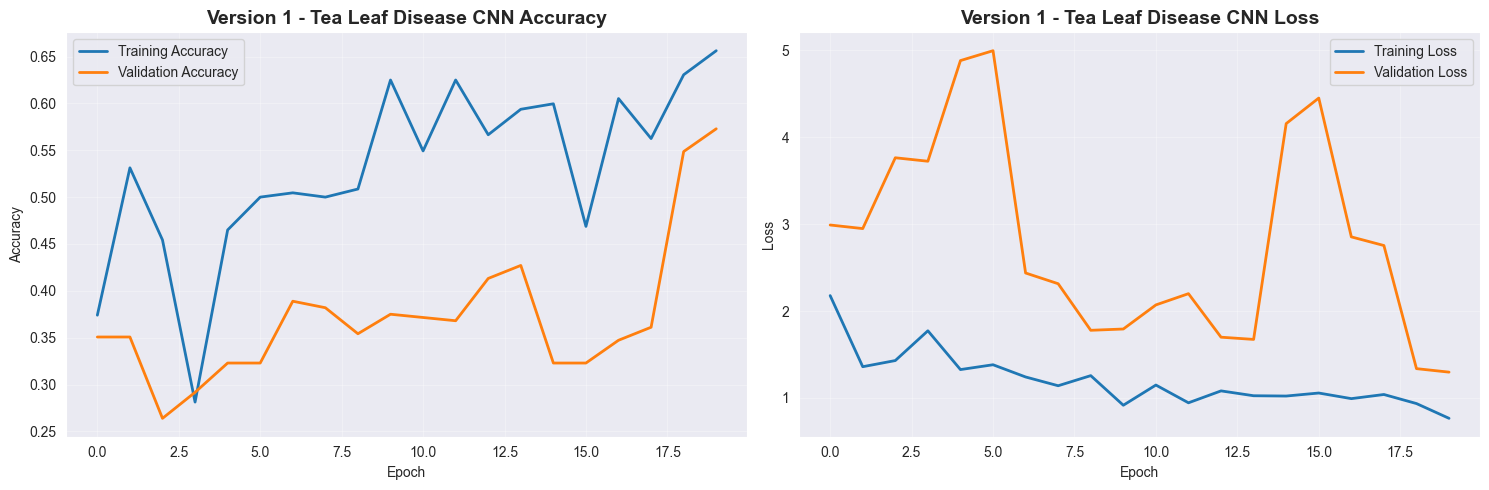

In [15]:

def plot_training_history(history, version_name):
    """
    Plot training and validation accuracy and loss curves
    for Tea Leaf Disease Classification.

    Args:
        history: Keras History object from model.fit()
        version_name: Name of the model/version for the plot title
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title(f'{version_name} - Tea Leaf Disease CNN Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot Loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title(f'{version_name} - Tea Leaf Disease CNN Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Plot training history for Version 1
plot_training_history(history_v1, "Version 1")


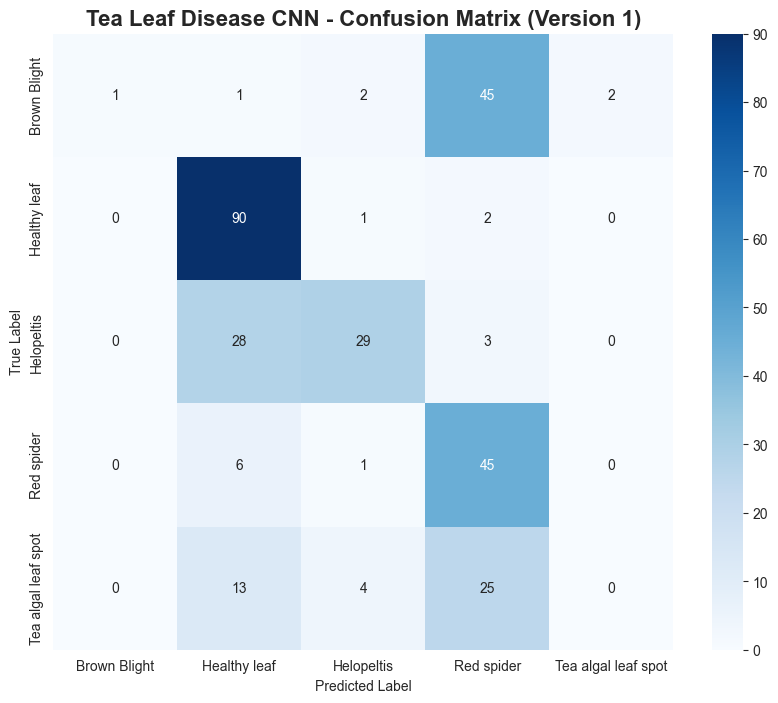

In [17]:

def plot_confusion_matrix(true_classes, predicted_classes, class_names, version_name):
    """
    Plot a confusion matrix heatmap for multi-class classification.

    Args:
        true_classes: Array of true labels
        predicted_classes: Array of predicted labels
        class_names: List of class names
        version_name: Name of the model/version for the plot title

    Returns:
        cm: Confusion matrix array
    """
    cm = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Tea Leaf Disease CNN - Confusion Matrix ({version_name})', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return cm


# Plot confusion matrix for Version 1
cm_v1 = plot_confusion_matrix(true_classes_v1, predicted_classes_v1, class_names, "Version 1")


In [18]:

def simple_cross_validation(model_func, data_path, k_folds=3):
    """
    Perform simple cross validation using existing train/val folders.

    Args:
        model_func: Function that returns a compiled CNN model
        data_path: Path to dataset folder containing 'train' and 'val'
        k_folds: Number of folds (simulated by shuffling seeds)

    Returns:
        cv_scores: List of best validation accuracies per fold
    """
    cv_scores = []

    for fold in range(k_folds):
        print(f"\n=== Cross Validation Fold {fold + 1}/{k_folds} ===")

        # Training generator with augmentation
        train_gen = ImageDataGenerator(
            rescale=1. / 255,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2
        ).flow_from_directory(
            os.path.join(data_path, 'train'),
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True,
            seed=42 + fold * 10
        )

        # Validation generator (no augmentation)
        val_gen = ImageDataGenerator(rescale=1. / 255).flow_from_directory(
            os.path.join(data_path, 'val'),
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False,
            seed=42 + fold * 10
        )

        # Create and compile a new model for this fold
        cv_model = model_func()
        cv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Train model
        cv_history = cv_model.fit(
            train_gen,
            steps_per_epoch=len(train_gen),
            epochs=20,
            validation_data=val_gen,
            validation_steps=len(val_gen),
            verbose=1
        )

        # Record best validation accuracy
        best_acc = max(cv_history.history['val_accuracy'])
        cv_scores.append(best_acc)
        print(f"Fold {fold + 1} Best Validation Accuracy: {best_acc:.4f}")

    return cv_scores


print("Starting Cross Validation for Tea Leaf Disease CNN...")
cv_scores = simple_cross_validation(create_cnn_model, dataset_path, k_folds=3)

print("\n=== Cross Validation Results ===")
print(f"Fold Accuracies: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f}")
print(f"CV Standard Deviation: {np.std(cv_scores):.4f}")



Starting Cross Validation for Tea Leaf Disease CNN...

=== Cross Validation Fold 1/3 ===
Found 2000 images belonging to 5 classes.
Found 298 images belonging to 5 classes.


C:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 281s 4s/step - accuracy: 0.3685 - loss: 2.1824 - val_accuracy: 0.2148 - val_loss: 2.6315
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.4520 - loss: 1.3798 - val_accuracy: 0.4094 - val_loss: 2.5068
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.4785 - loss: 1.3305 - val_accuracy: 0.2416 - val_loss: 3.5394
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.5045 - loss: 1.2377 - val_accuracy: 0.2013 - val_loss: 3.4118
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.5120 - loss: 1.2269 - val_accuracy: 0.4664 - val_loss: 1.4561
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 270s 4s/step - accuracy: 0.5425 - loss: 1.1627 - val_accuracy: 0.4430 - val_loss: 1.8000
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.5460 - loss: 1.1253 - val_accuracy: 0.3423 - val_loss: 1.8958
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.5800 - loss: 1.0580 - val_accuracy: 0.3926 - v